In [43]:
import glob
import math
import os
from typing import Callable

from matplotlib import pyplot
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

In [44]:
# parameter: how many days to shift
n_days_lag = 14

# parameter: how many days to predict
n_days_test = 30

In [45]:
start = "2019-03-01"
end = "2023-03-01"

date_range = pd.date_range(start=start, end=end, freq="D")

In [46]:
df = pd.DataFrame()

df["Date"] = date_range
df.set_index("Date", inplace=True)

In [47]:
# exclude electricity, we don't have daily prices for it
def get_sentiment_files(folder_path: str) -> list[str]:
    return [file for file in glob.glob(os.path.join(folder_path, "*.csv")) if "_all" not in file and "Electricity" not in file]

In [48]:
def get_sentiment_file_parts(file_path: str) -> tuple[str, str]:
    file_name = os.path.basename(file_path)
    file_name_parts = file_name.split("_")

    return file_name_parts[1], file_name_parts[2]

In [49]:
# add sentiment columns to the given dataframe

def add_sentiment_columns(big_df: pd.DataFrame, folder_path: str) -> pd.DataFrame:
    files = get_sentiment_files(folder_path)

    for file in files:
        sentiment_df = pd.read_csv(file, index_col="Date", parse_dates=True)
        sentiment_df = sentiment_df.reindex(date_range)
        sentiment_df.rolling(window=3, min_periods=1).mean()
        sentiment_df = sentiment_df.bfill()

        source, name = get_sentiment_file_parts(file)

        sentiment_df.rename(columns={"Sentiment": f"{source} {name}"}, inplace=True)
        big_df = pd.merge(big_df, sentiment_df, how="left", left_index=True, right_index=True)

    return big_df

In [50]:
# exclude electricity, we don't have daily prices for it
def get_returns_files(folder_path: str) -> list[str]:
    return [file for file in glob.glob(os.path.join(folder_path, "*.csv")) if "Electricity" not in file]

In [51]:
# add returns columns to the given dataframe
def add_returns_column(big_df: pd.DataFrame, folder_path: str) -> pd.DataFrame:
    files = get_returns_files(folder_path)

    for file in files:
        daily_returns_df = pd.read_csv(file, index_col="Date", parse_dates=True)

        daily_returns_df = daily_returns_df.reindex(date_range)

        name = os.path.basename(file).replace(".csv", "").split("_")[2]

        daily_returns_df.rename(columns={"Daily Return": f"{name} Daily Return"}, inplace=True)
        big_df = pd.merge(big_df, daily_returns_df, how="left", left_index=True, right_index=True)

    return big_df

In [52]:
metrics = ["EMA 20", "EMA 50", "SMA 10", "SMA 20", "SMA 30", "SMA 50"]


# add metrics columns to the given dataframe
def add_metrics_columns(big_df: pd.DataFrame, col: str) -> pd.DataFrame:
    for metric in metrics:
        metric_type, metric_days = metric.split(" ")

        if metric_type == "SMA":
            big_df[f"{col} {metric}"] = big_df[col].rolling(int(metric_days)).mean().shift(n_days_lag)
        elif metric_type == "EMA":
            big_df[f"{col} {metric}"] = big_df[col].ewm(int(metric_days)).mean().shift(n_days_lag)

    return big_df

In [53]:
data_sources = ["GDELT", "Google News", "Twitter", "Prices"]
daily_returns_labels = ["BSE Daily Return", "Crude Oil Daily Return", "Dow Jones Daily Return", "FTSE Daily Return", "Gold Daily Return", "Hang Seng Daily Return", "Natural Gas Daily Return", "S&P500 Daily Return"]

# parameter: a function that returns the path to the folders that contain the average daily sentiments. The folders are structured as follows: Data\{data_source}\Sentiment
sentiments_path: Callable[[str], str] = lambda x: f"D:\data-science-project\Data\{x}\Sentiment"
daily_returns_path = os.path.join(".", "Data")

In [54]:
df = add_returns_column(df, daily_returns_path)

In [55]:
df = df.shift(n_days_lag)
df.bfill(inplace=True)

In [56]:
df.isna().sum()

BSE Daily Return            0
Crude Oil Daily Return      0
Dow Jones Daily Return      0
FTSE Daily Return           0
Gold Daily Return           0
Hang Seng Daily Return      0
Natural Gas Daily Return    0
S&P500 Daily Return         0
dtype: int64

In [57]:
def smape(a: np.ndarray, f: np.ndarray):
    return 1 / len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)) * 100)

In [58]:
os.makedirs("plots", exist_ok=True)

In [59]:
def train(models_path: str = "models", suffix: str = ""):
    for label in daily_returns_labels:
        x = add_metrics_columns(df.copy(), label).drop(label, axis=1)
        y = df[label]

        # print([col for col in x.columns if "SMA" in col or "EMA" in col])

        x_train, x_test = x[:-n_days_test], x[-n_days_test:]
        y_train, y_test = y[:-n_days_test], y[-n_days_test:]

        print(f"Training {label} model")

        model = xgb.XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, random_state=42, objective="reg:squarederror")
        model.fit(x_train, y_train)
        model.save_model(os.path.join(models_path, f"{label}_{suffix}.json" if suffix else f"{label}.json"))

        result = model.predict(x_test)

        print(f"MAE: {mean_absolute_error(y_test, result)}")
        print(f"SMAPE: {smape(result, y_test)}")
        print(f"RMSE: {math.sqrt(mean_squared_error(y_test, result))}")
        print(f"R2: {r2_score(y_test, result)}")
        print()

        test = pd.DataFrame({"True": y_test, "Prediction": result})
        test.plot(figsize=(12, 7), title=f"{label} Actual vs Predicted")
        pyplot.savefig(os.path.join("plots", f"{label}_{suffix}.png" if suffix else f"{label}.png"))

In [60]:
os.makedirs("models", exist_ok=True)

Training BSE Daily Return model
MAE: 0.005387881189385951
SMAPE: 134.5691464357824
RMSE: 0.007497159078435592
R2: -0.9553356364190639

Training Crude Oil Daily Return model
MAE: 0.01171349023266515
SMAPE: 150.75109192361379
RMSE: 0.014195335953250085
R2: 0.06794875654392385

Training Dow Jones Daily Return model
MAE: 0.002653549404048674
SMAPE: 74.46591681060772
RMSE: 0.003906947781449014
R2: 0.5234250103067919

Training FTSE Daily Return model
MAE: 0.002447336795849411
SMAPE: 87.1807759964853
RMSE: 0.003545364504471627
R2: 0.13208097271506358

Training Gold Daily Return model
MAE: 0.004668800427891788
SMAPE: 145.52847701749855
RMSE: 0.007477055667019336
R2: -0.45174256240702015

Training Hang Seng Daily Return model
MAE: 0.0072252780854654185
SMAPE: 127.07359389712876
RMSE: 0.0097352308882498
R2: -0.3045086964951562

Training Natural Gas Daily Return model
MAE: 0.035741498448227875
SMAPE: 150.76280830997976
RMSE: 0.04501255477455472
R2: -0.9668034475533225

Training S&P500 Daily Retur

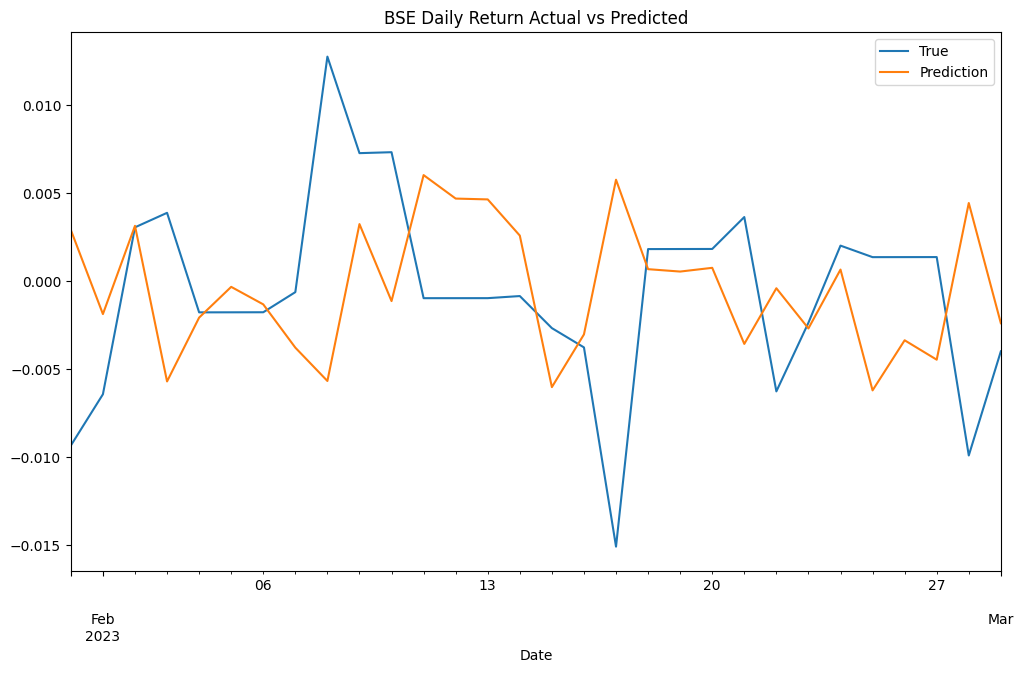

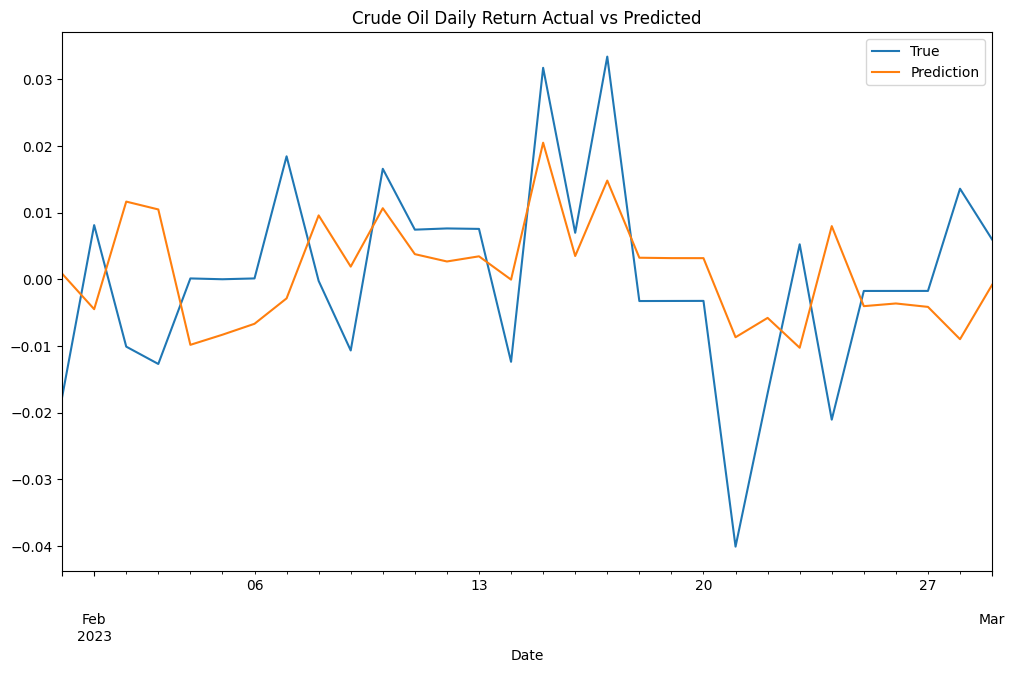

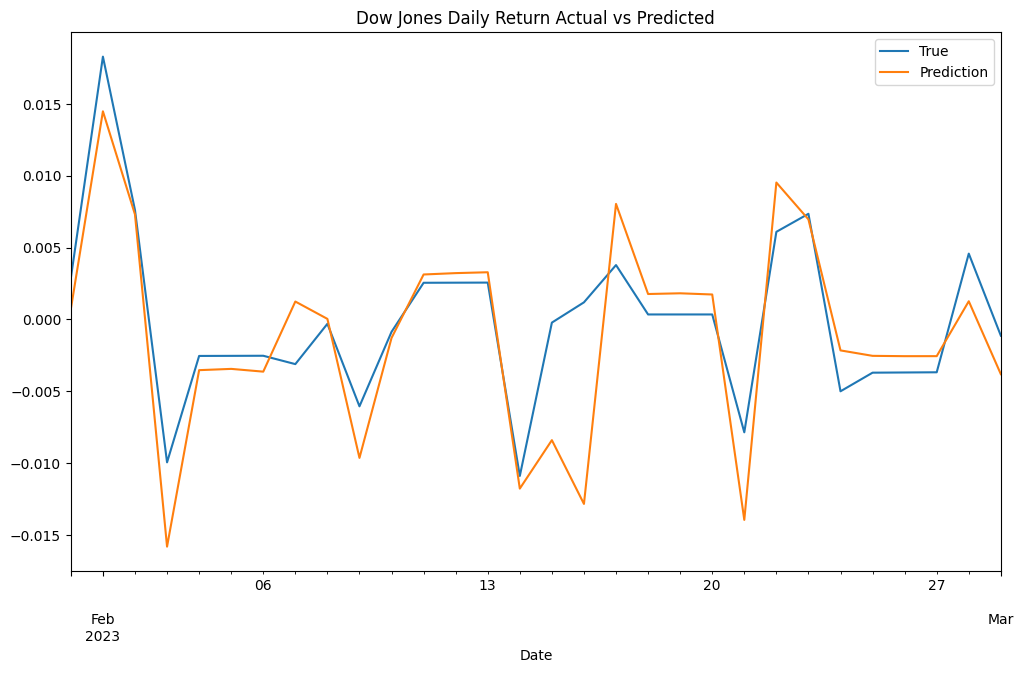

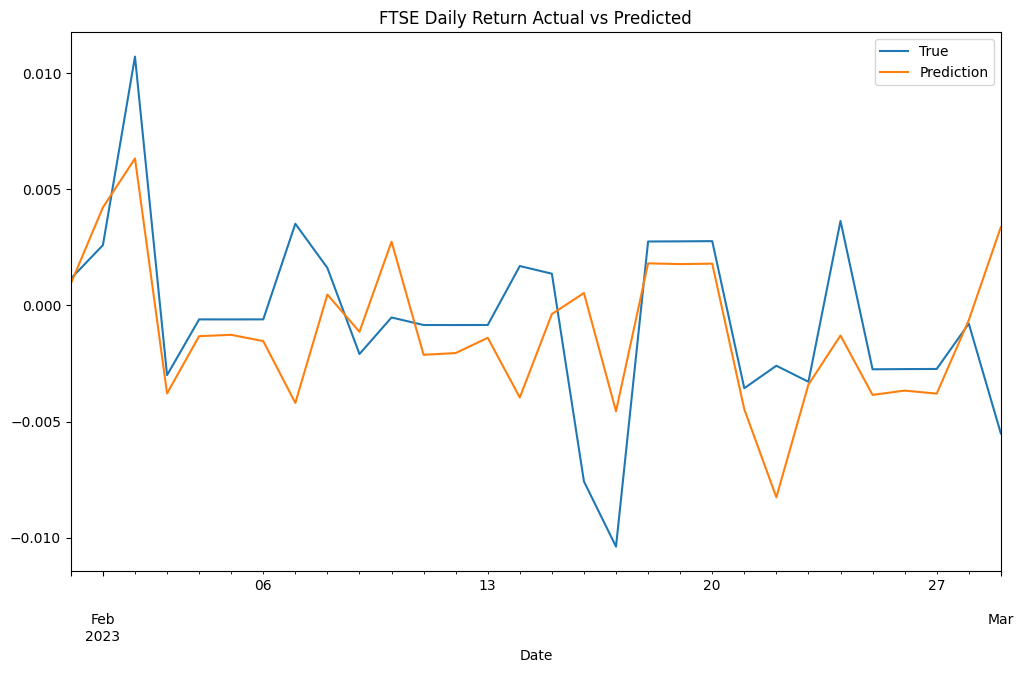

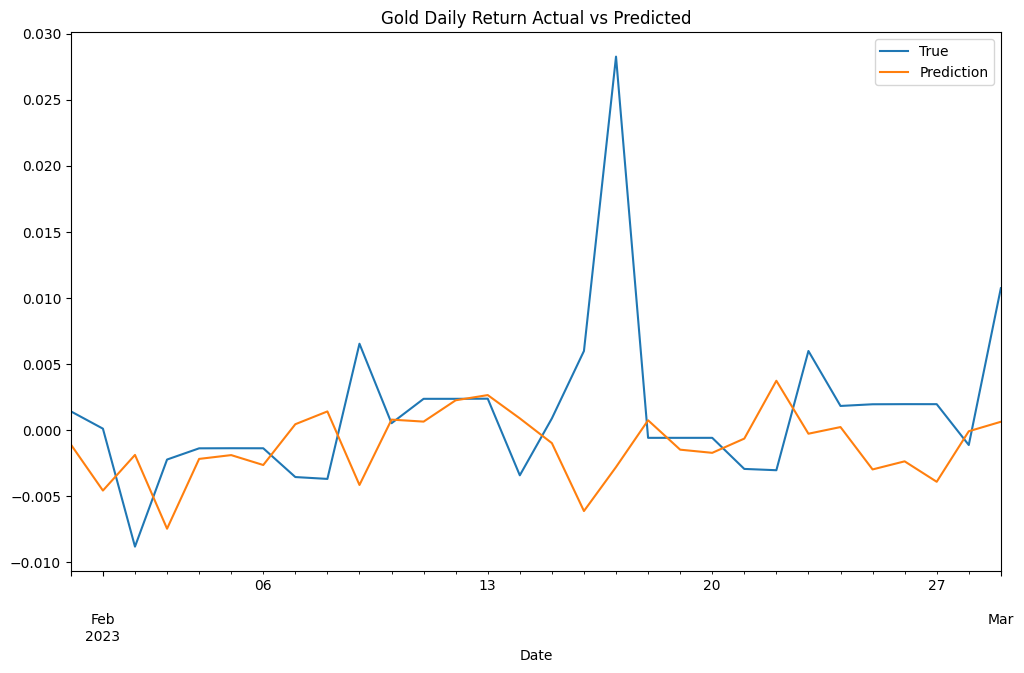

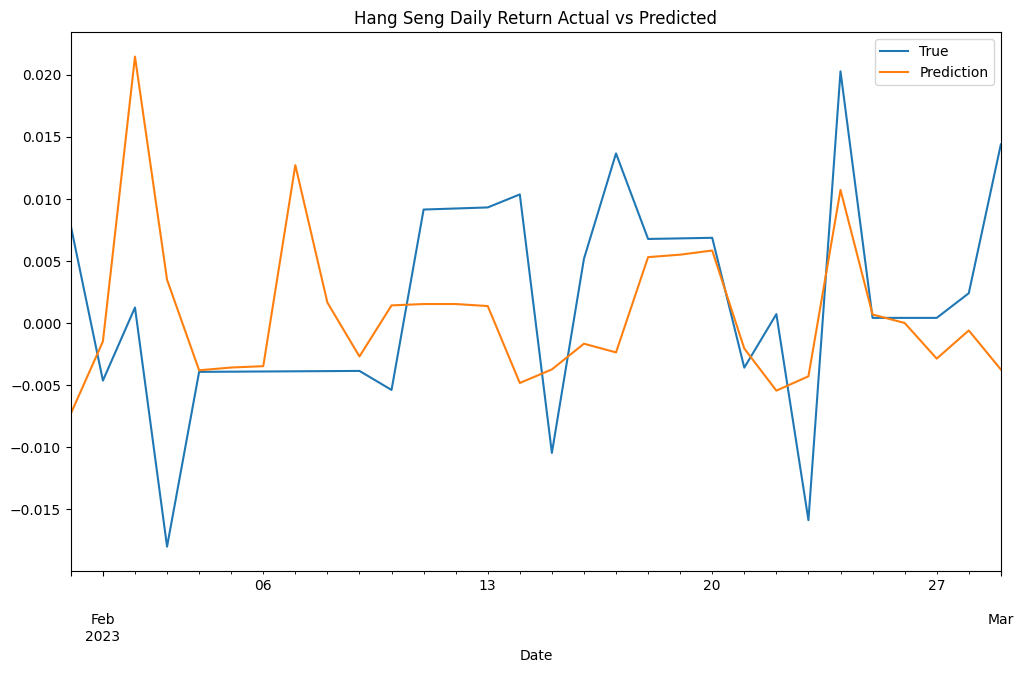

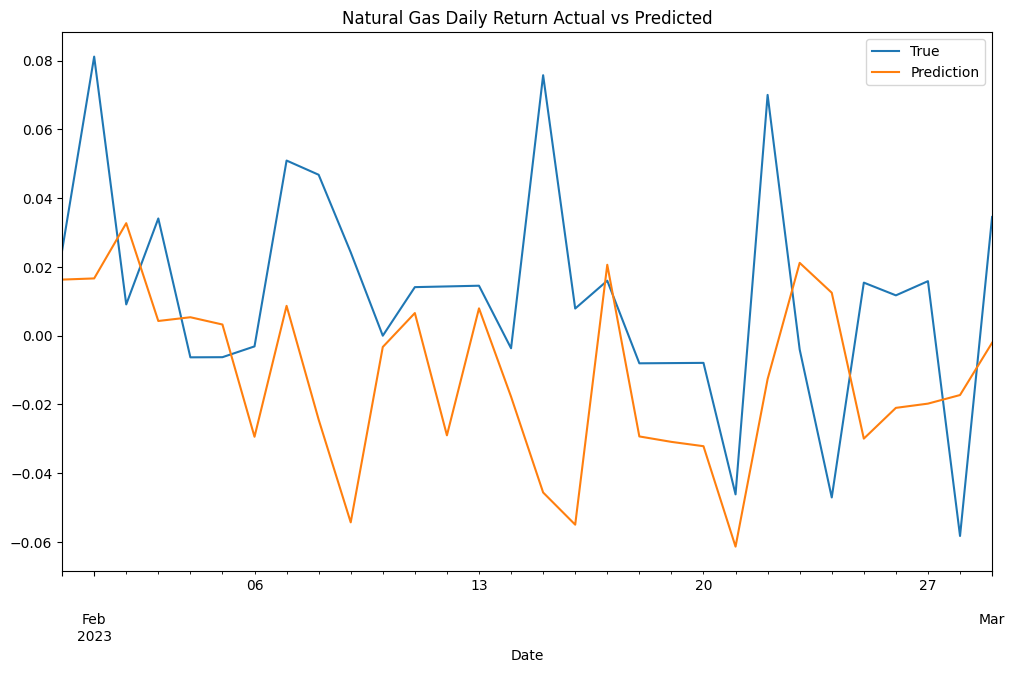

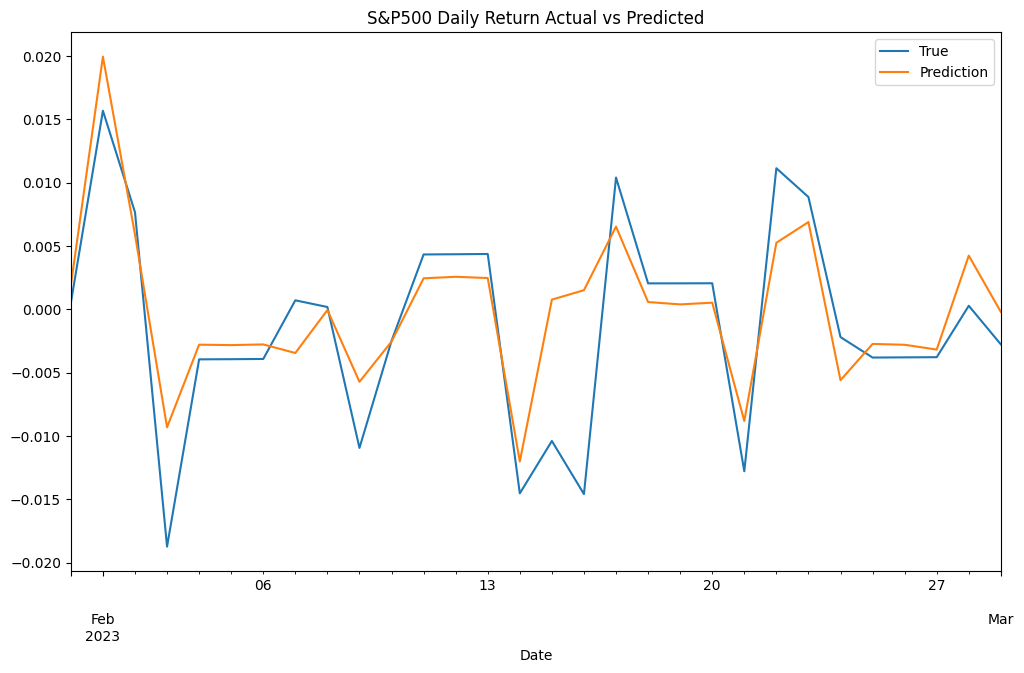

In [61]:
train("models")

In [62]:
for data_source in data_sources:
    df = add_sentiment_columns(df, sentiments_path(data_source))

Training BSE Daily Return model
MAE: 0.005018657877668508
SMAPE: 143.19033220289725
RMSE: 0.0066573025926379235
R2: -0.5417872786452838

Training Crude Oil Daily Return model
MAE: 0.012057925573659891
SMAPE: 160.92902042265092
RMSE: 0.015267682530891953
R2: -0.0781884657108185

Training Dow Jones Daily Return model
MAE: 0.002731284122361338
SMAPE: 81.18394924155177
RMSE: 0.003908990110255464
R2: 0.5229266277928226

Training FTSE Daily Return model
MAE: 0.0029922170279193952
SMAPE: 126.78637161436932
RMSE: 0.00398593171927613
R2: -0.09702653986893273

Training Gold Daily Return model
MAE: 0.004498793988246522
SMAPE: 132.71621021772805
RMSE: 0.0077399627869222205
R2: -0.5556293450872081

Training Hang Seng Daily Return model
MAE: 0.008085158953559907
SMAPE: 151.14467944077873
RMSE: 0.009534332734831553
R2: -0.2512240251731406

Training Natural Gas Daily Return model
MAE: 0.033907401962460754
SMAPE: 148.89020063208983
RMSE: 0.04132133118878715
R2: -0.6574568977105664

Training S&P500 Dail

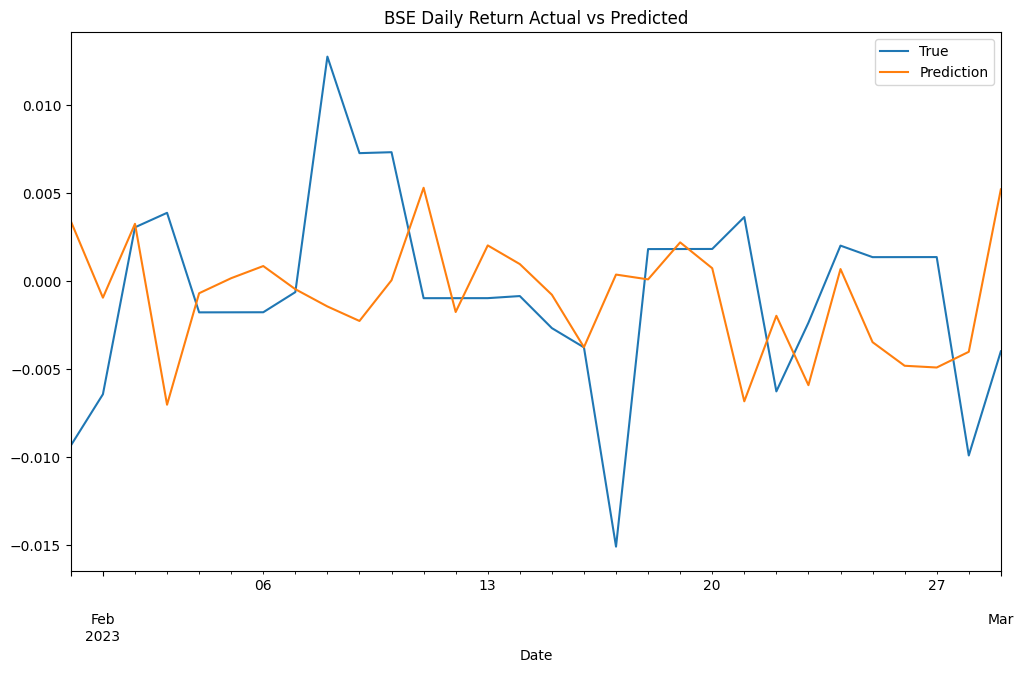

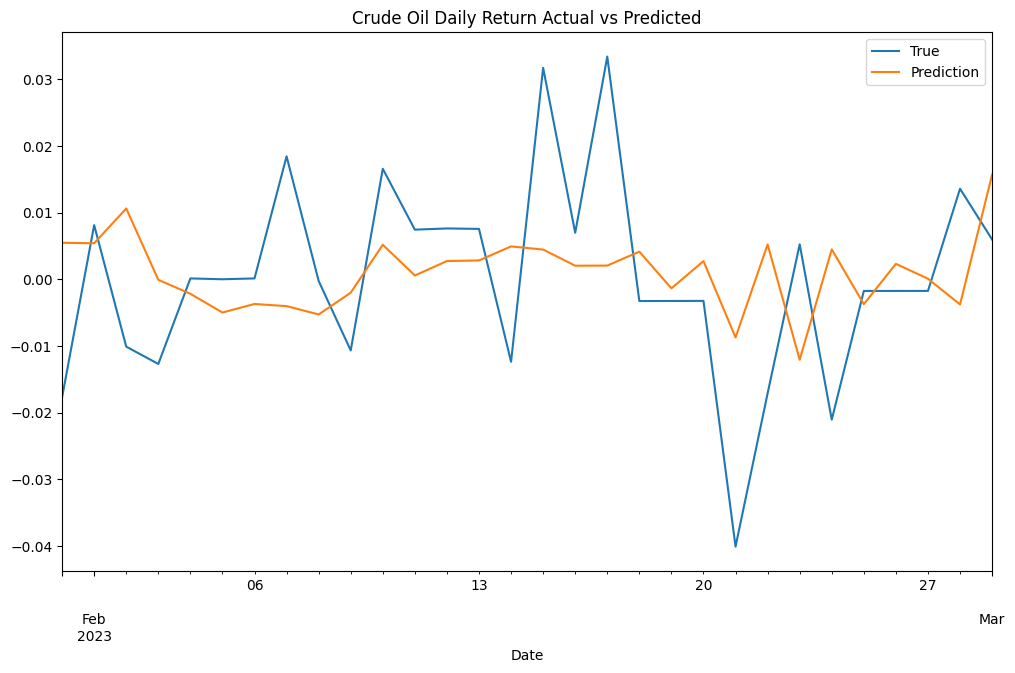

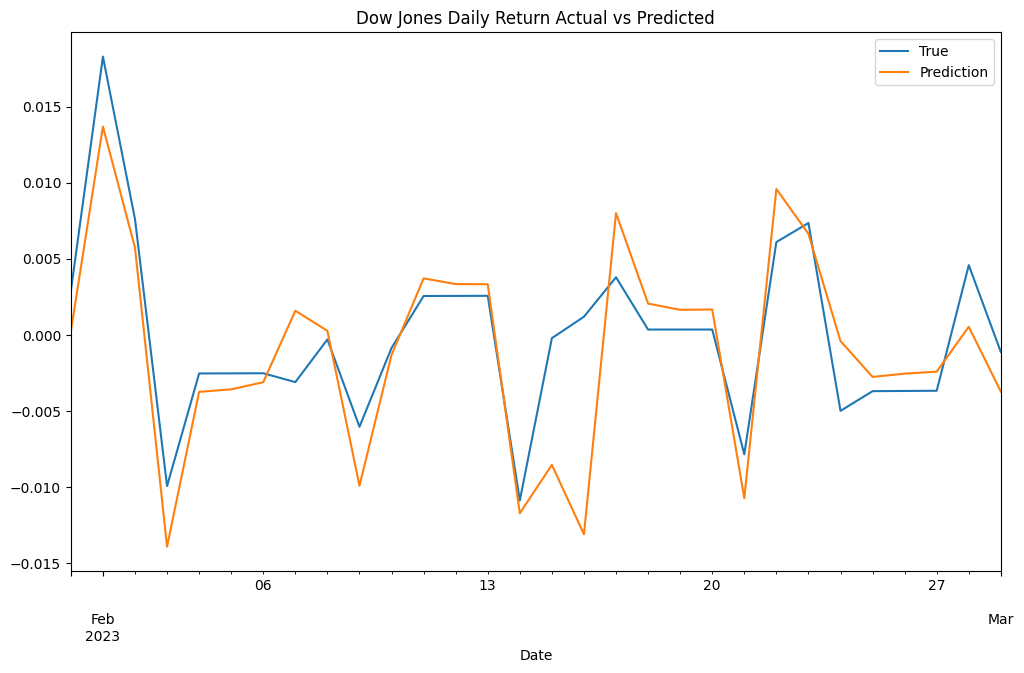

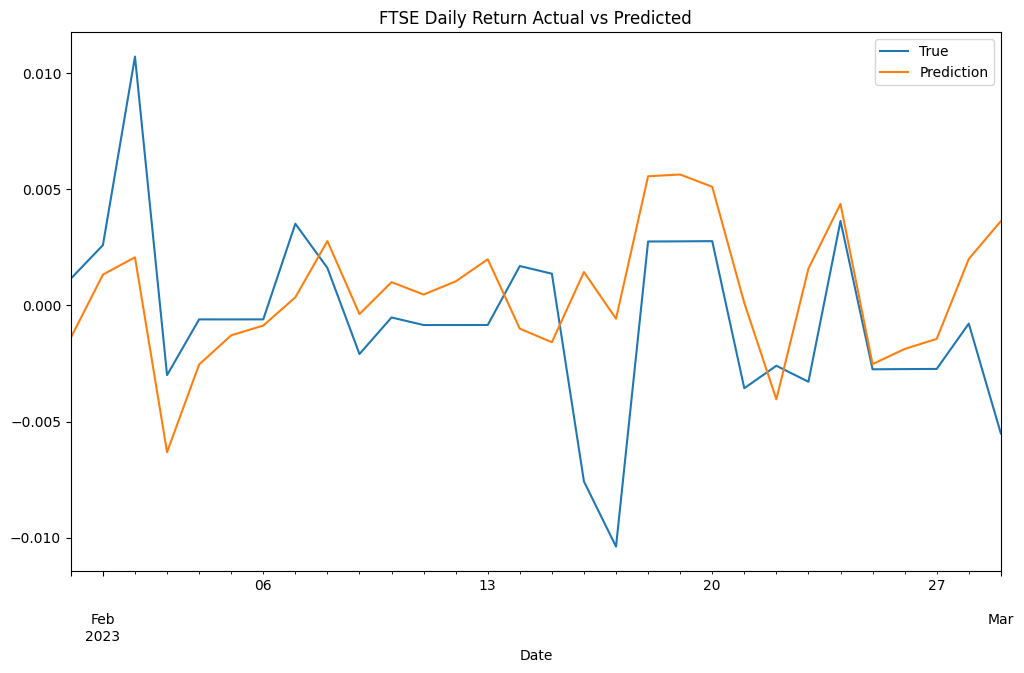

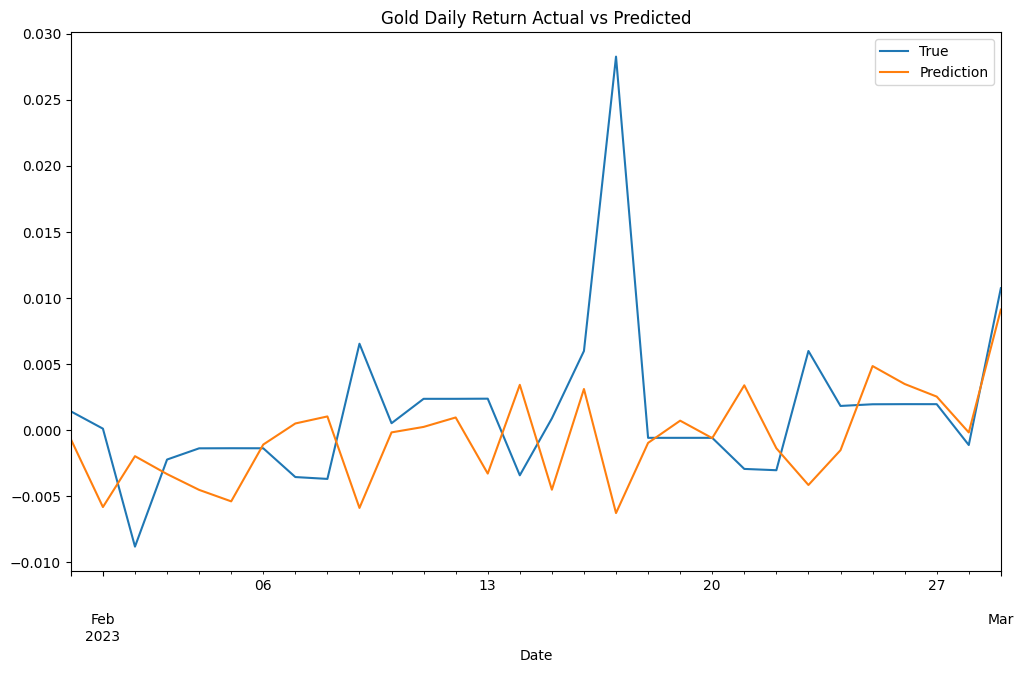

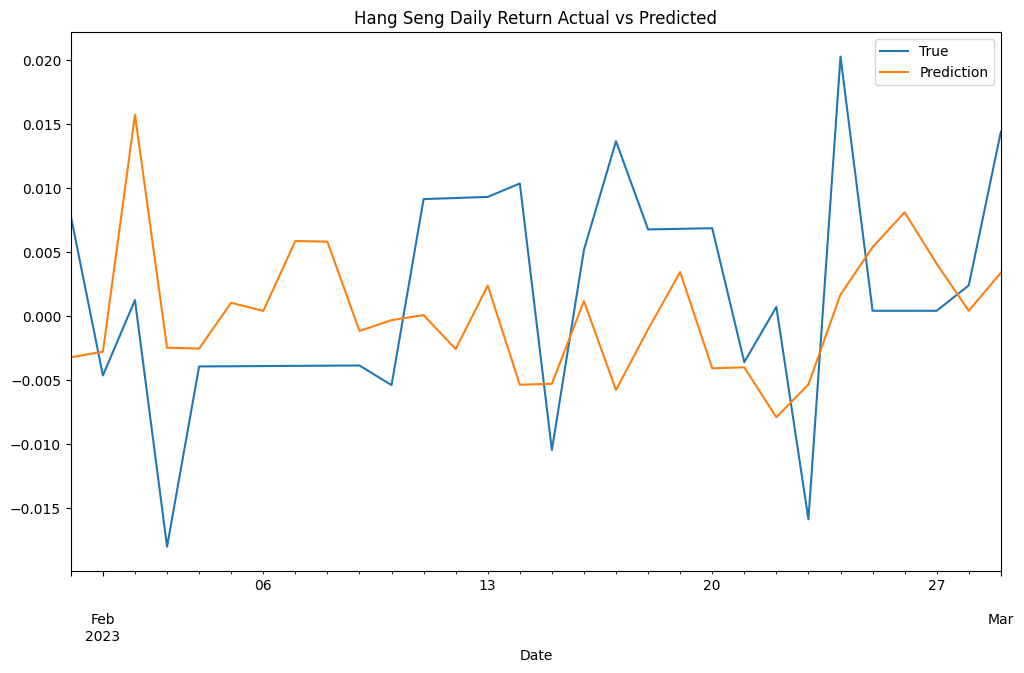

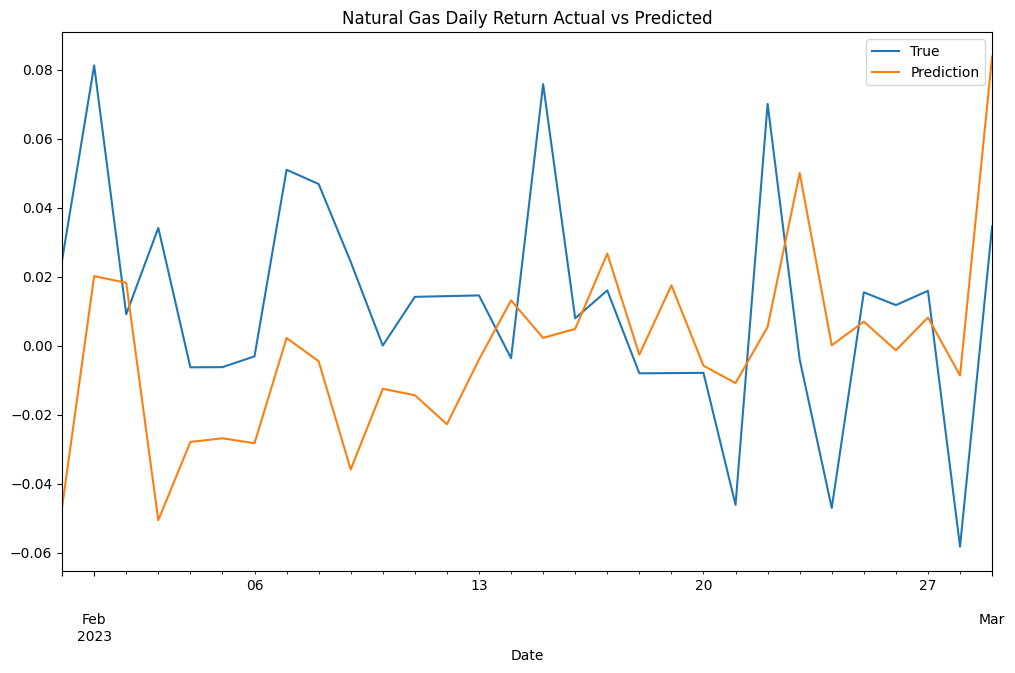

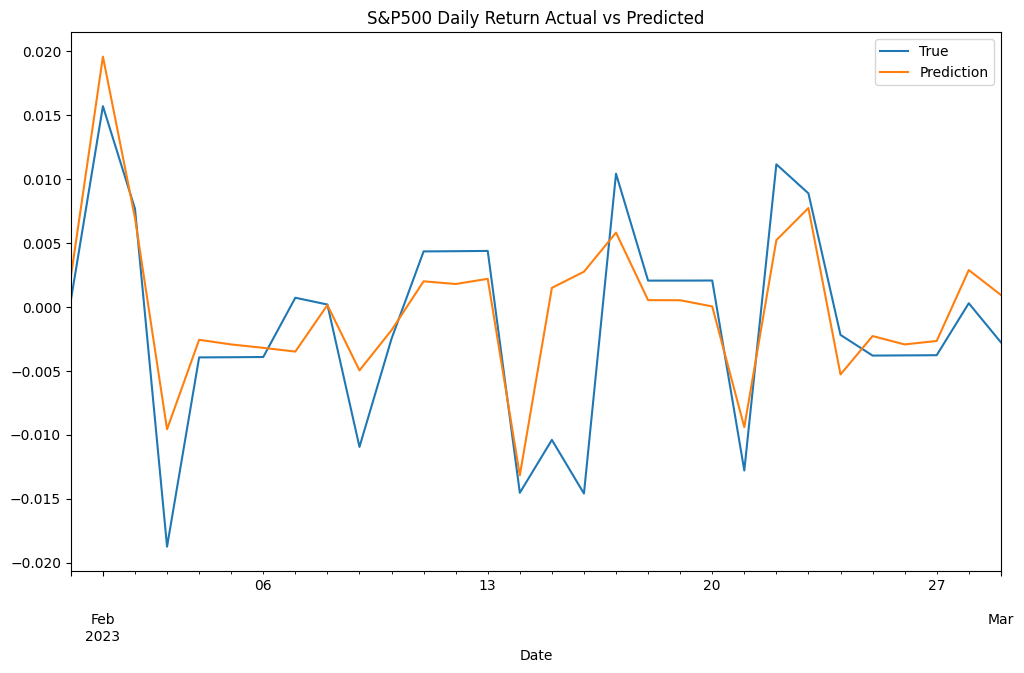

In [63]:
train("models", "sentiment")